# Project: Image classification

G4: Mónia, Moritz, Fabian

## Preperations

### Import needed libaries

In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as ts
import keras
from sklearn import metrics
from keras.backend import clear_session
from keras.src.optimizers import Adam, SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Softmax, BatchNormalization, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

%matplotlib inline

### Load the CIFAR-10

More information: [CIFAR-10 at cs.toronto.edu](https://www.cs.toronto.edu/~kriz/cifar.html)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Check provided dataset

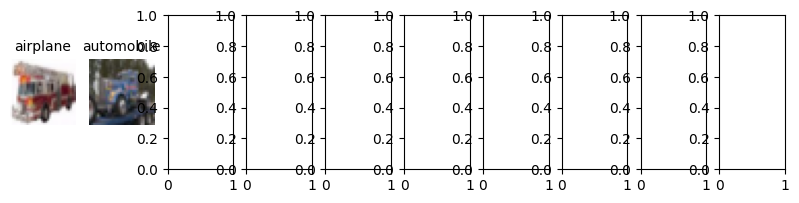

In [ ]:
# Create a figure and axes for plotting
fig, axes = plt.subplots(1, 10, figsize=(10, 2))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Get the unique classes in CIFAR-10
classes = np.unique(y_train)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loop through each class
for i, cls in enumerate(classes):
  # Filter images belonging to the current class
  class_indices = np.where(y_train == cls)[0]

  # Randomly select 1 image from the filtered indices
  random_idx = np.random.choice(class_indices, 1, replace=False)[0]

  axes[i].imshow(x_train[random_idx])
  axes[i].axis('off')
  axes[i].set_title(class_names[i], fontsize=10)

# Display the plot
plt.show()

### Preprocessing

As images are arrays of RGB colors, with a range from 0 - 255 we're deviding the colors by 255 to get normalized data.

Labels are converted to the One-hot encoded format

In [ ]:
# Normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Reusable methods

#### Confusion matrix

The confusion matrix shows the counts of true positives, true negatives, false positives, and false negatives for each class, revealing how well the model predicts different classes.

In [ ]:
def show_confusion_matrix(y_test_data, prediction, name):
    """
    Args:
        y_test_data (numpy.ndarray): The true labels of the test data.
        prediction (numpy.ndarray): The predicted labels of the test data.
        name (str): The name of the file for saving the confusion matrix image (saved as a PNG).
    Returns:
        None: The function displays the confusion matrix and saves it as a PNG file.
    """

    prediction = np.argmax(prediction, axis=1)
    gt = np.argmax(y_test_data, axis=1)

    cm = metrics.confusion_matrix(gt, prediction)
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(f"output/confusion_matrix_{name}.png")
    plt.show()

#### Comparison Graph

Generates and displays a comparison graph of training and validation loss and accuracy.

In [ ]:
def show_compare_graph(cnn_history, name):
    """
    Args:
        cnn_history (History object): The history object returned by the `model.fit()` method, containing loss and accuracy data.
        name (str): The name of the file for saving the comparison graph image (saved as a PNG).

    Returns:
        None: The function displays the comparison graph and saves it as a PNG file.
    """

    plt.title('Loss / Accuracy')
    plt.plot(cnn_history.history['loss'], color='#ff8080', label='train')
    plt.plot(cnn_history.history['accuracy'], color='#80ff80', label='train')
    plt.plot(cnn_history.history['val_loss'], color='#b30000', label='val')
    plt.plot(cnn_history.history['val_accuracy'], color='#008f00', label='val')
    plt.savefig(f"output/compare_graph_{name}.png")
    plt.show()

#### Classification Report

Generates and prints a classification report for model predictions, comparing the predicted and actual labels.

In [ ]:
def show_classification_report(y_test_data, prediction):
    """
    Args:
        y_test_data (numpy.ndarray): Ground truth labels in one-hot encoded format.
        prediction (numpy.ndarray): Model predictions (as probabilities or logits), which will be converted to class predictions.

    Returns:
        None: The function prints the classification report to the console, including precision, recall, F1-score, and support.
    """

    prediction = np.argmax(prediction, axis=1)
    y_data_argmax = np.argmax(y_test_data, axis=1)
    print(metrics.classification_report(y_data_argmax, prediction))

#### Prediction Info

Randomly selects and displays images from the test dataset, showing the actual and predicted labels for each image.

In [ ]:
def show_prediction_info(y_test_data, x_test_data, prediction):
    for i in range(3):
        index = np.random.randint(0, len(y_test_data))
        plt.figure(figsize=(2,2))
        plt.imshow(x_test_data[index, :])
        plt.xlabel(f"Predicted: {class_names[np.argmax(prediction[index])]}", fontsize=10)
        plt.ylabel(class_names[np.argmax(y_test_data[index])], fontsize=10)
        plt.show()

#### Evaluate Model

 Evaluates the performance of a CNN model by generating predictions and displaying key metrics and visualizations.

In [ ]:
def evaluate_model(cnn_model, cnn_history, x_test_data, y_test_data, name):
    """
    Args:
        y_test_data (numpy.ndarray): Ground truth labels in one-hot encoded format.
        x_test_data (numpy.ndarray): Test images corresponding to the ground truth labels.
        prediction (numpy.ndarray): Model predictions (as probabilities or logits), which will be converted to class predictions.

    Returns:
        None: The function displays three images from the test set, with predicted and actual labels.
    """

    prediction = cnn_model.predict(x_test_data)

    show_confusion_matrix(y_test_data, prediction, name)
    show_compare_graph(cnn_history, name)
    show_classification_report(y_test_data, prediction)
    show_prediction_info(y_test_data, x_test_data, prediction)

## Models

### Model 1

A simple sequential model with one convolutional layer followed by flattening and two dense layers.

In [ ]:
clear_session()

In [ ]:
# Define the CNN model
model = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(32, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 32 filters
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=60, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2010 - loss: 2.2171 - val_accuracy: 0.3131 - val_loss: 1.9877
Epoch 2/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3069 - loss: 1.9720 - val_accuracy: 0.3418 - val_loss: 1.8854
Epoch 3/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3451 - loss: 1.8782 - val_accuracy: 0.3426 - val_loss: 1.8484
Epoch 4/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3575 - loss: 1.8243 - val_accuracy: 0.3786 - val_loss: 1.7945
Epoch 5/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3763 - loss: 1.7830 - val_accuracy: 0.3938 - val_loss: 1.7432
Epoch 6/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3890 - loss: 1.7460 - val_accuracy: 0.3987 - val_loss: 1.7161
Epoch 7/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4025 - loss: 1.7157 - val_accuracy: 0.4107 - val_loss: 1.6846
Epoch 8/60
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4145 - loss: 1.6832 - val_accuracy: 0.4186 - v

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


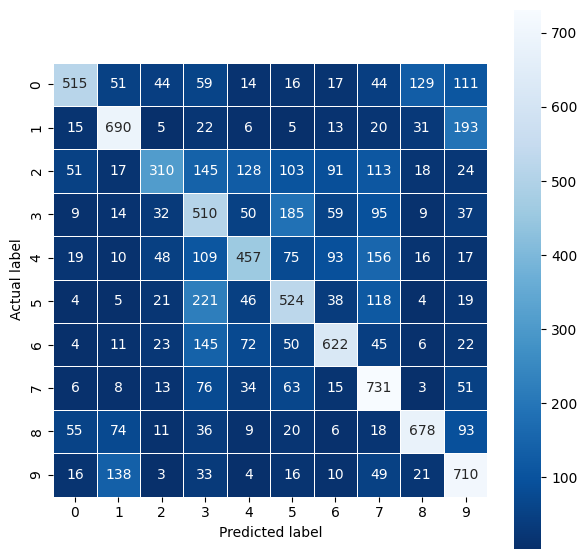

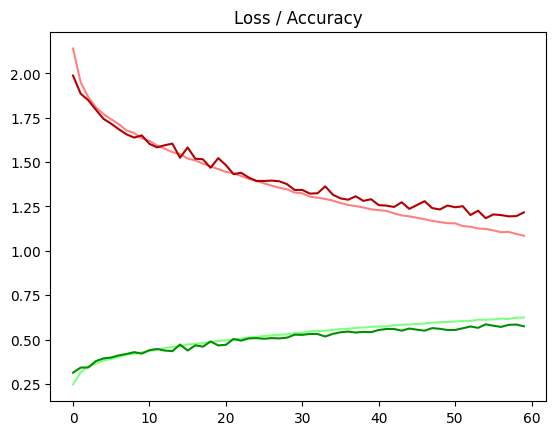

              precision    recall  f1-score   support

           0       0.74      0.52      0.61      1000
           1       0.68      0.69      0.68      1000
           2       0.61      0.31      0.41      1000
           3       0.38      0.51      0.43      1000
           4       0.56      0.46      0.50      1000
           5       0.50      0.52      0.51      1000
           6       0.65      0.62      0.63      1000
           7       0.53      0.73      0.61      1000
           8       0.74      0.68      0.71      1000
           9       0.56      0.71      0.62      1000

    accuracy                           0.57     10000
   macro avg       0.59      0.57      0.57     10000
weighted avg       0.59      0.57      0.57     10000



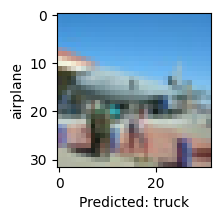

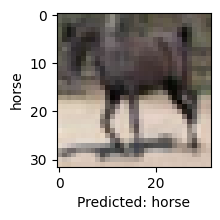

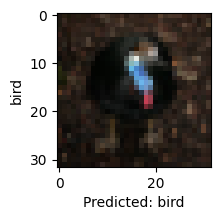

In [ ]:
evaluate_model(model, history, x_test, y_test, 'model_1')

As we can see, the result is not very good. The loss is higher as the accuracy

In [ ]:
clear_session()

### Model 2

This model introduces BatchNormalization and Dropout, along with an additional convolutional layer compared to Model 1.

In [ ]:
# Define the CNN model
model2 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Dropout(0.25), # Set a Dropout of 0.25
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Compile model
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history2 = model2.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.3055 - loss: 2.0991 - val_accuracy: 0.1595 - val_loss: 2.4300
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4689 - loss: 1.4676 - val_accuracy: 0.2004 - val_loss: 2.7644
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5249 - loss: 1.3204 - val_accuracy: 0.2091 - val_loss: 2.5463
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5602 - loss: 1.2329 - val_accuracy: 0.3488 - val_loss: 1.8739
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5852 - loss: 1.1531 - val_accuracy: 0.4892 - val_loss: 1.4431
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6117 - loss: 1.0844 - val_accuracy: 0.5864 - val_loss: 1.1735
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6314 - loss: 1.0319 - val_accuracy: 0.5583 - val_loss: 1.2665
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6521 - loss: 0.9800 - val_accuracy: 0.6262 -

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


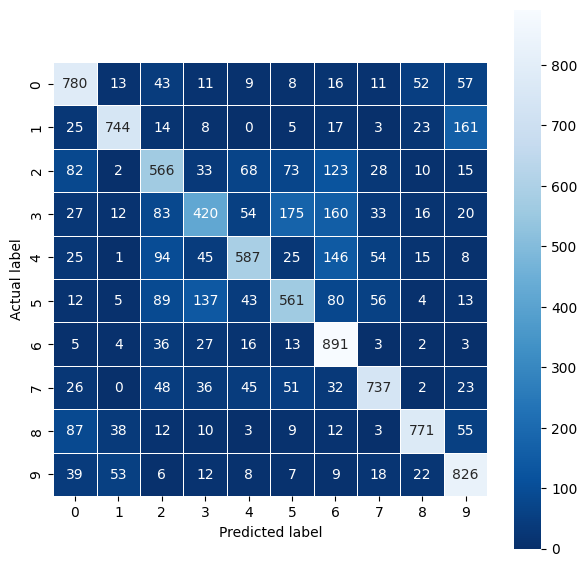

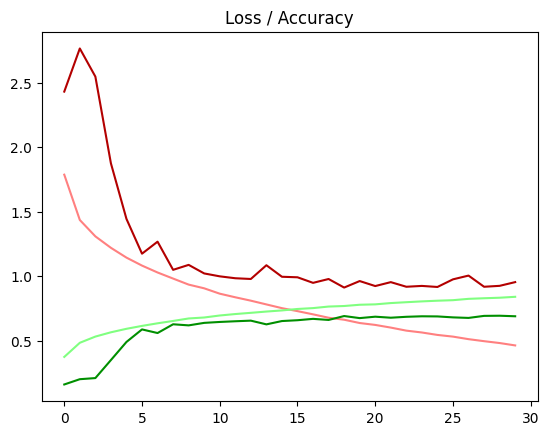

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1000
           1       0.85      0.74      0.79      1000
           2       0.57      0.57      0.57      1000
           3       0.57      0.42      0.48      1000
           4       0.70      0.59      0.64      1000
           5       0.61      0.56      0.58      1000
           6       0.60      0.89      0.72      1000
           7       0.78      0.74      0.76      1000
           8       0.84      0.77      0.80      1000
           9       0.70      0.83      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.68     10000
weighted avg       0.69      0.69      0.68     10000



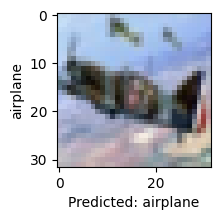

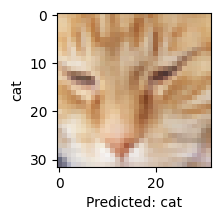

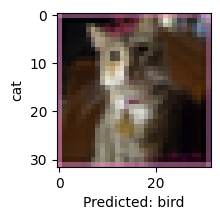

In [ ]:
evaluate_model(model2, history2, x_test, y_test, 'model_2')

In [ ]:
clear_session()

### Model 3

Increases complexity with two sets of convolutional layers (64 and 128 filters), BatchNormalization, MaxPooling, and Dropout.

In [ ]:
# Define the CNN model
model3 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Dropout(0.25), # Set a Dropout of 0.25
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Compile model
model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history3 = model3.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.3039 - loss: 2.1589 - val_accuracy: 0.1130 - val_loss: 2.5847
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.4786 - loss: 1.4435 - val_accuracy: 0.1374 - val_loss: 3.0561
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5403 - loss: 1.2777 - val_accuracy: 0.1868 - val_loss: 3.1035
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5763 - loss: 1.1754 - val_accuracy: 0.2479 - val_loss: 2.5070
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6098 - loss: 1.0829 - val_accuracy: 0.4360 - val_loss: 1.6290
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6404 - loss: 1.0081 - val_accuracy: 0.5924 - val_loss: 1.1522
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6587 - loss: 0.9512 - val_accuracy: 0.5801 - val_loss: 1.1633
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6794 - loss: 0.9045 - val_accuracy: 0.6417 -

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


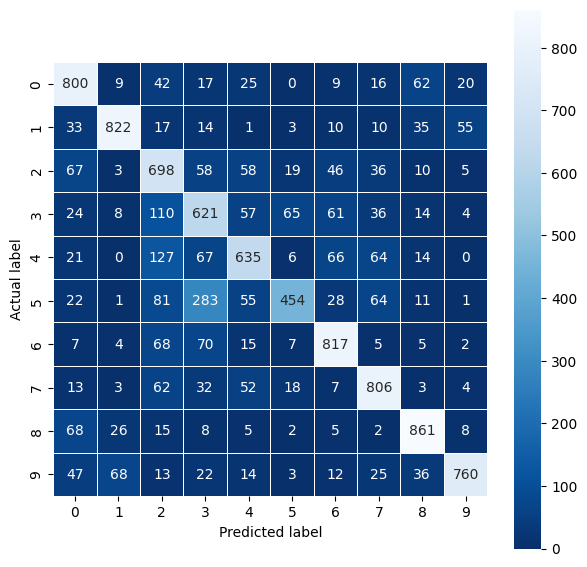

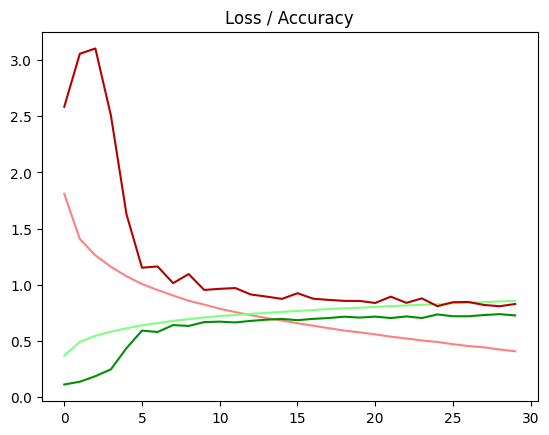

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1000
           1       0.87      0.82      0.85      1000
           2       0.57      0.70      0.63      1000
           3       0.52      0.62      0.57      1000
           4       0.69      0.64      0.66      1000
           5       0.79      0.45      0.58      1000
           6       0.77      0.82      0.79      1000
           7       0.76      0.81      0.78      1000
           8       0.82      0.86      0.84      1000
           9       0.88      0.76      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



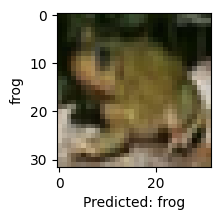

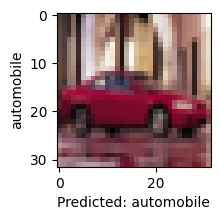

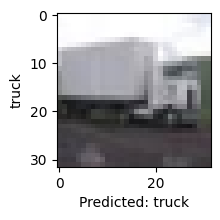

In [ ]:
evaluate_model(model3, history3, x_test, y_test, 'model_3')

In [ ]:
clear_session()

### Model 4

Similar to Model 3 but replaces Flatten with GlobalAveragePooling2D for dimensionality reduction.

In [ ]:
# Define the CNN model
model4 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Dropout(0.25), # Set a Dropout of 0.25
    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Compile model
model4.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history4 = model4.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.2770 - loss: 2.0233 - val_accuracy: 0.1000 - val_loss: 2.3875
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.4207 - loss: 1.6176 - val_accuracy: 0.1113 - val_loss: 2.6548
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.4686 - loss: 1.4872 - val_accuracy: 0.1437 - val_loss: 2.8022
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5030 - loss: 1.4009 - val_accuracy: 0.1933 - val_loss: 2.5898
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5259 - loss: 1.3365 - val_accuracy: 0.3134 - val_loss: 1.9932
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5459 - loss: 1.2857 - val_accuracy: 0.4358 - val_loss: 1.5695
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5592 - loss: 1.2413 - val_accuracy: 0.5244 - val_loss: 1.3389
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5744 - loss: 1.2055 - val_accuracy: 0.5020 -

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


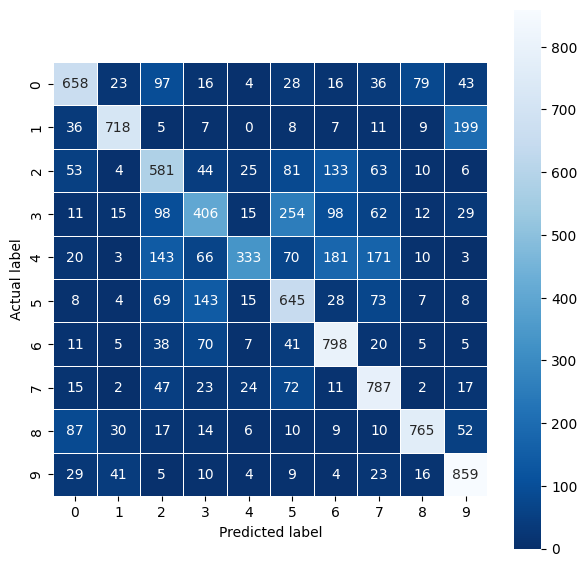

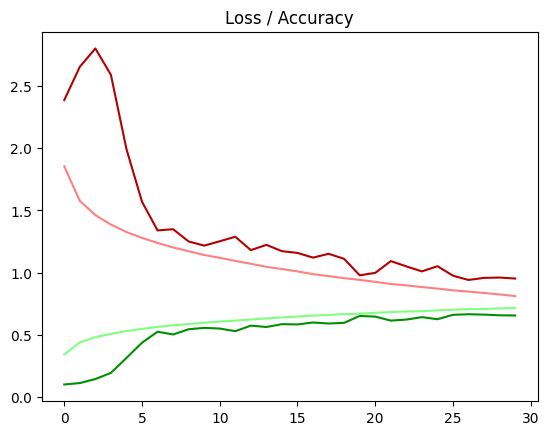

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1000
           1       0.85      0.72      0.78      1000
           2       0.53      0.58      0.55      1000
           3       0.51      0.41      0.45      1000
           4       0.77      0.33      0.46      1000
           5       0.53      0.65      0.58      1000
           6       0.62      0.80      0.70      1000
           7       0.63      0.79      0.70      1000
           8       0.84      0.77      0.80      1000
           9       0.70      0.86      0.77      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.65     10000
weighted avg       0.67      0.66      0.65     10000



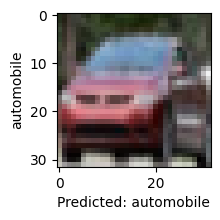

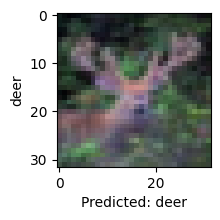

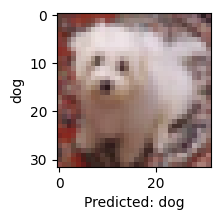

In [ ]:
evaluate_model(model4, history4, x_test, y_test, 'model_4')

### Model 5

Uses the Adam optimizer instead of SGD, showing potential improvements in training efficiency and accuracy.

In [ ]:
# Define the CNN model
model5 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Dropout(0.25), # Set a Dropout of 0.25
    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Compile model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history5 = model5.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test))

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3827 - loss: 1.6892 - val_accuracy: 0.1000 - val_loss: 3.2997
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5989 - loss: 1.1092 - val_accuracy: 0.1000 - val_loss: 5.5121
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6789 - loss: 0.9086 - val_accuracy: 0.1000 - val_loss: 7.6093
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7349 - loss: 0.7564 - val_accuracy: 0.1000 - val_loss: 6.3495
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7720 - loss: 0.6575 - val_accuracy: 0.1397 - val_loss: 3.8823
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.7982 - loss: 0.5785 - val_accuracy: 0.4977 - val_loss: 1.4541
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8289 - loss: 0.4942 - val_accuracy: 0.6662 - val_loss: 0.9467
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8493 - loss: 0.4404 - val_accuracy: 0.7408 -

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


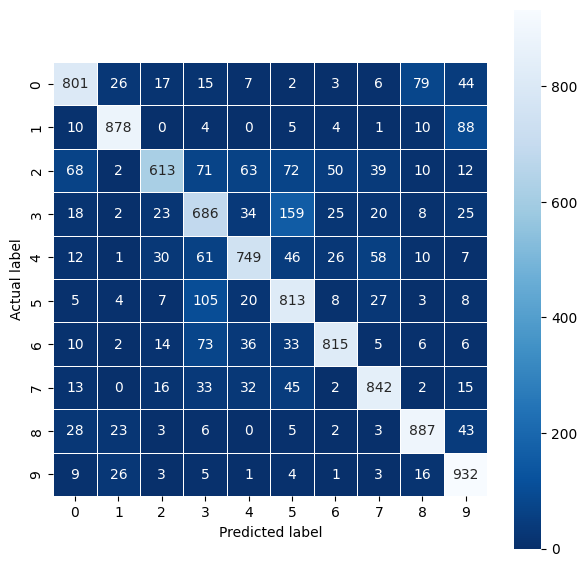

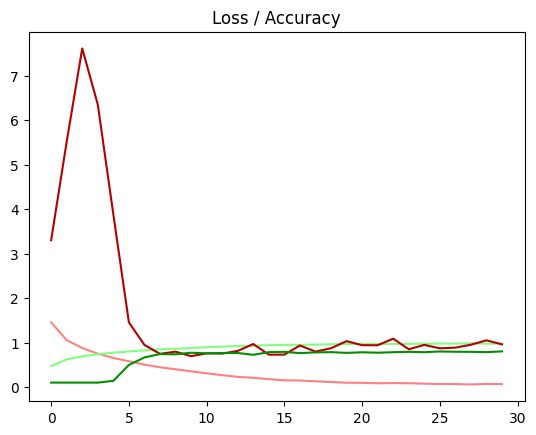

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1000
           1       0.91      0.88      0.89      1000
           2       0.84      0.61      0.71      1000
           3       0.65      0.69      0.67      1000
           4       0.80      0.75      0.77      1000
           5       0.69      0.81      0.74      1000
           6       0.87      0.81      0.84      1000
           7       0.84      0.84      0.84      1000
           8       0.86      0.89      0.87      1000
           9       0.79      0.93      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



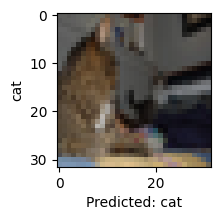

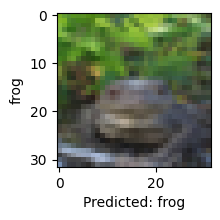

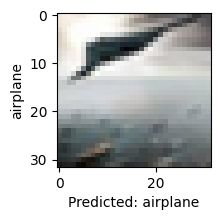

In [ ]:
evaluate_model(model5, history5, x_test, y_test, 'model_5')

### Model 6

 Incorporates EarlyStopping to prevent overfitting and potentially improve generalization.

In [ ]:
# Define the CNN model
model6 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)), # Add a max pooling layer
    Dropout(0.25), # Set a Dropout of 0.25
    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile model
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history6 = model6.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test), callbacks=[early_stopping])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.3809 - loss: 1.7014 - val_accuracy: 0.1000 - val_loss: 3.0746
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.6008 - loss: 1.1078 - val_accuracy: 0.1000 - val_loss: 3.7176
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6840 - loss: 0.8876 - val_accuracy: 0.1485 - val_loss: 3.1745
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7266 - loss: 0.7794 - val_accuracy: 0.1384 - val_loss: 3.2301
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7654 - loss: 0.6657 - val_accuracy: 0.1673 - val_loss: 2.4109
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.7956 - loss: 0.5889 - val_accuracy: 0.5346 - val_loss: 1.2669
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8270 - loss: 0.5036 - val_accuracy: 0.5816 - val_loss: 1.1732
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8465 - loss: 0.4482 - val_accuracy: 0.7777 -

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


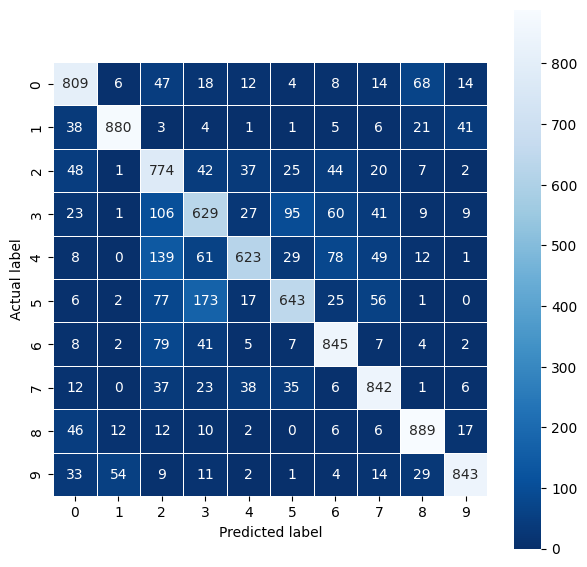

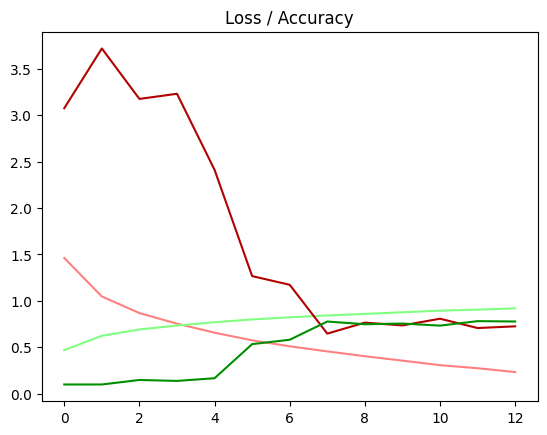

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1000
           1       0.92      0.88      0.90      1000
           2       0.60      0.77      0.68      1000
           3       0.62      0.63      0.63      1000
           4       0.82      0.62      0.71      1000
           5       0.77      0.64      0.70      1000
           6       0.78      0.84      0.81      1000
           7       0.80      0.84      0.82      1000
           8       0.85      0.89      0.87      1000
           9       0.90      0.84      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



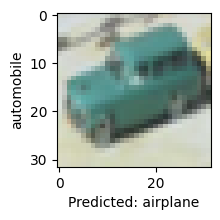

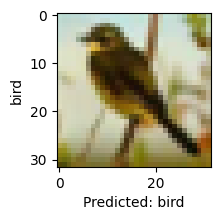

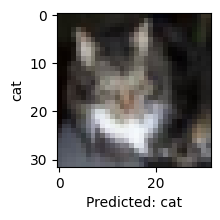

In [ ]:
evaluate_model(model6, history6, x_test, y_test, 'model_6')

In [ ]:
clear_session()

### Model 7

Adds another set of convolutional layers with 256 filters, increasing the depth and learning capacity of the network.

In [ ]:
# Define the CNN model
model7 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile model
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history7 = model7.fit(x_train, y_train, epochs=30, batch_size=512, validation_data=(x_test, y_test), callbacks=[early_stopping])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step - accuracy: 0.4027 - loss: 1.7038 - val_accuracy: 0.1000 - val_loss: 3.1762
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.6461 - loss: 0.9981 - val_accuracy: 0.1045 - val_loss: 3.7492
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.7290 - loss: 0.7745 - val_accuracy: 0.1304 - val_loss: 3.9747
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.7840 - loss: 0.6201 - val_accuracy: 0.1347 - val_loss: 4.1052
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.8135 - loss: 0.5259 - val_accuracy: 0.4192 - val_loss: 1.8587
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8473 - loss: 0.4439 - val_accuracy: 0.7526 - val_loss: 0.7280
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8687 - loss: 0.3801 - val_accuracy: 0.7988 - val_loss: 0.5905
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8825 - loss: 0.3380 - val_accu

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


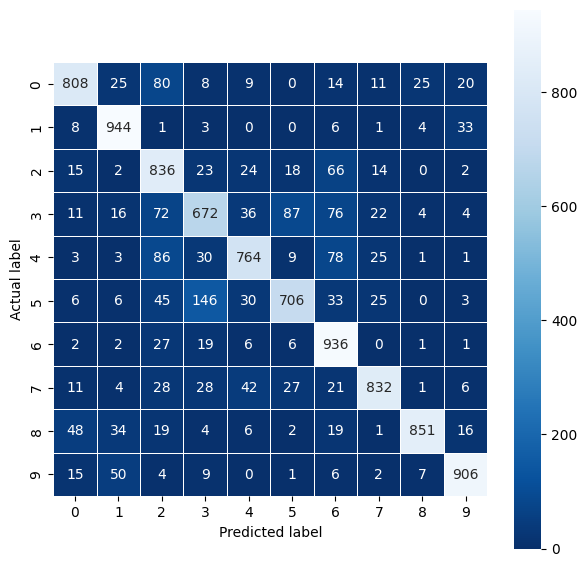

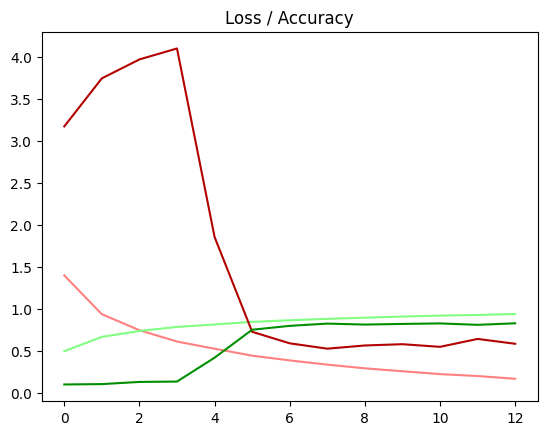

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1000
           1       0.87      0.94      0.91      1000
           2       0.70      0.84      0.76      1000
           3       0.71      0.67      0.69      1000
           4       0.83      0.76      0.80      1000
           5       0.82      0.71      0.76      1000
           6       0.75      0.94      0.83      1000
           7       0.89      0.83      0.86      1000
           8       0.95      0.85      0.90      1000
           9       0.91      0.91      0.91      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



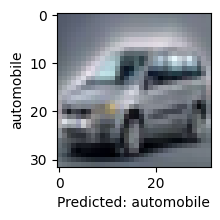

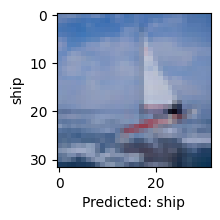

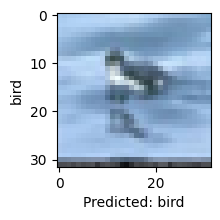

In [ ]:
evaluate_model(model7, history7, x_test, y_test, 'model_7')

In [ ]:
clear_session()

### Model 8

Maintains the architecture of Model 7 but reduces the batch size to 128, potentially leading to finer gradient updates during training.

In [ ]:
# Define the CNN model
model8 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile model
model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history8 = model8.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test), callbacks=[early_stopping])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.4518 - loss: 1.5260 - val_accuracy: 0.1748 - val_loss: 4.9739
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.7091 - loss: 0.8232 - val_accuracy: 0.6327 - val_loss: 1.1651
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.7795 - loss: 0.6326 - val_accuracy: 0.7537 - val_loss: 0.7239
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8219 - loss: 0.5076 - val_accuracy: 0.7694 - val_loss: 0.7102
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8538 - loss: 0.4167 - val_accuracy: 0.7964 - val_loss: 0.6097
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8767 - loss: 0.3529 - val_accuracy: 0.8271 - val_loss: 0.5178
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8910 - loss: 0.3077 - val_accuracy: 0.7866 - val_loss: 0.6963
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9082 - loss: 0.2656 - 

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


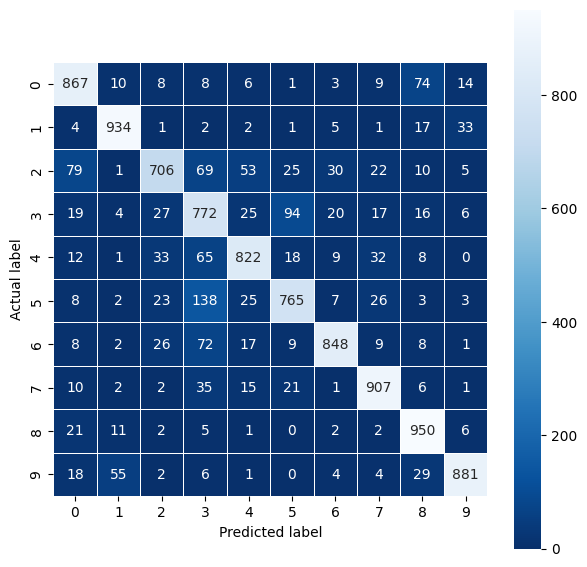

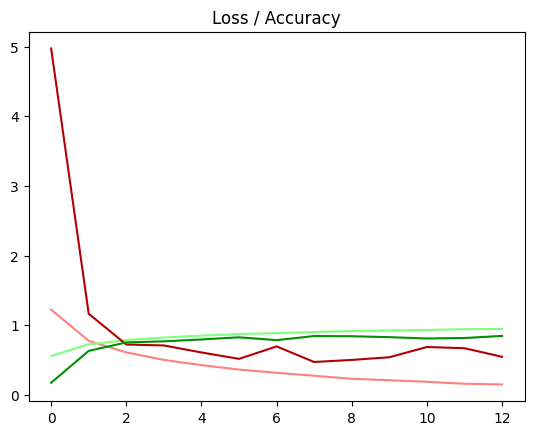

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.91      0.93      0.92      1000
           2       0.85      0.71      0.77      1000
           3       0.66      0.77      0.71      1000
           4       0.85      0.82      0.84      1000
           5       0.82      0.77      0.79      1000
           6       0.91      0.85      0.88      1000
           7       0.88      0.91      0.89      1000
           8       0.85      0.95      0.90      1000
           9       0.93      0.88      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



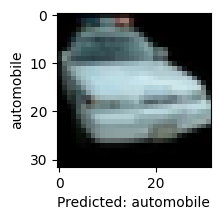

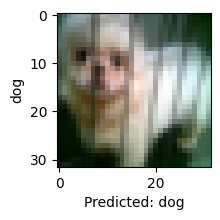

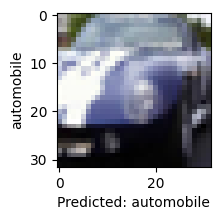

In [ ]:
evaluate_model(model8, history8, x_test, y_test, 'model_8')

In [ ]:
clear_session()

### Model 9

Employs ImageDataGenerator for data augmentation, introducing variations in the training data to improve robustness.

In [ ]:
# Define the CNN model
model9 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile model
model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history9 = model9.fit(train_generator, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stopping])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.4130 - loss: 1.6137 - val_accuracy: 0.1865 - val_loss: 3.0451
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.6412 - loss: 1.0068 - val_accuracy: 0.6152 - val_loss: 1.2470
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.7222 - loss: 0.7879 - val_accuracy: 0.7011 - val_loss: 0.8829
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.7654 - loss: 0.6710 - val_accuracy: 0.7791 - val_loss: 0.6548
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.7876 - loss: 0.6075 - val_accuracy: 0.7897 - val_loss: 0.6155
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.8072 - loss: 0.5479 - val_accuracy: 0.7635 - val_loss: 0.7099
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.8253 - loss: 0.5034 - val_accuracy: 0.8162 - val_loss: 0.5453
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.8383 - loss: 0.4669 - val_accurac

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


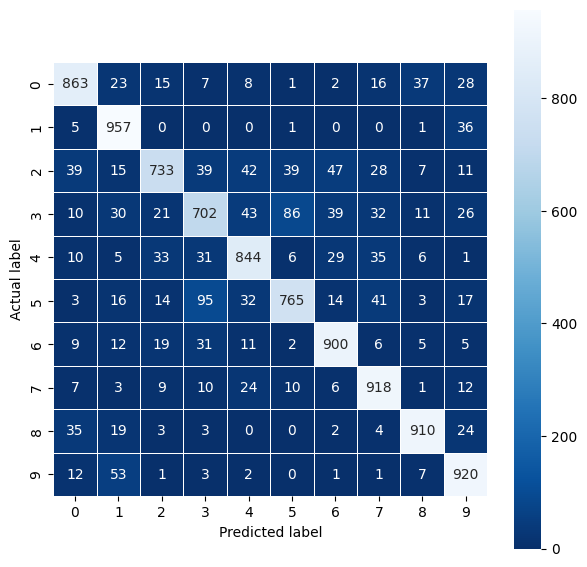

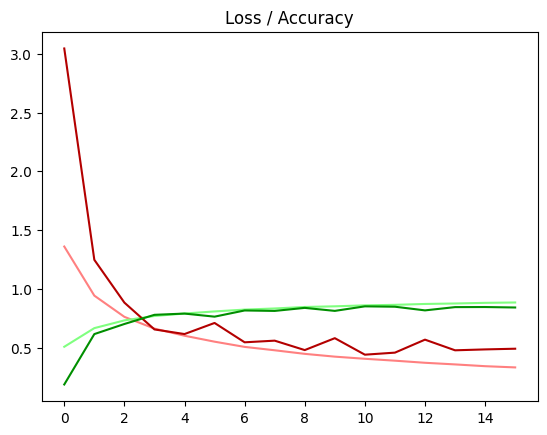

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1000
           1       0.84      0.96      0.90      1000
           2       0.86      0.73      0.79      1000
           3       0.76      0.70      0.73      1000
           4       0.84      0.84      0.84      1000
           5       0.84      0.77      0.80      1000
           6       0.87      0.90      0.88      1000
           7       0.85      0.92      0.88      1000
           8       0.92      0.91      0.92      1000
           9       0.85      0.92      0.88      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



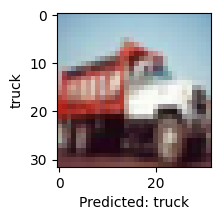

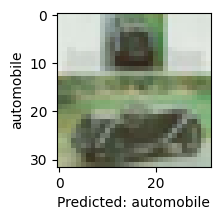

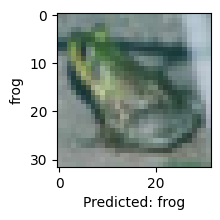

In [ ]:
evaluate_model(model9, history9, x_test, y_test, 'model_9')

In [ ]:
clear_session()

### Model 10

Combines data augmentation (ImageDataGenerator) with a reduced learning rate for the Adam optimizer, aiming for better convergence.

In [ ]:
# Define the CNN model
model10 = Sequential([
    Input(shape=(32, 32, 3)), # Set input shape (32, 32, 3)
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(64, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 64 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(128, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    Conv2D(256, (3, 3), activation='relu', padding='same'), # Add a convolutional layer with a 3x3 filter, 128 filters
    BatchNormalization(), # Add a max pooling layer
    MaxPooling2D((2, 2)),
    Dropout(0.25), # Set a Dropout of 0.25

    GlobalAveragePooling2D(), # Add a global average pooling layer
    Flatten(), # Flatten the feature maps
    Dense(100, activation='relu'), # Add a dense layer with 100 units
    Dense(10, activation='softmax') # Add the output classification layer with softmax activation for 10 classes
])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# change learning rate
optimizer = Adam(learning_rate=0.001)

# Compile model
model10.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history10 = model10.fit(train_generator, epochs=25, validation_data=(x_test, y_test), callbacks=[early_stopping])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - accuracy: 0.4098 - loss: 1.6425 - val_accuracy: 0.1644 - val_loss: 3.1061
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.6488 - loss: 0.9907 - val_accuracy: 0.6783 - val_loss: 0.9405
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.7245 - loss: 0.7867 - val_accuracy: 0.6797 - val_loss: 0.9913
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.7672 - loss: 0.6697 - val_accuracy: 0.7700 - val_loss: 0.6686
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.7873 - loss: 0.6087 - val_accuracy: 0.7550 - val_loss: 0.7274
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.8063 - loss: 0.5516 - val_accuracy: 0.7784 - val_loss: 0.6454
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.8229 - loss: 0.5041 - val_accuracy: 0.7696 - val_loss: 0.7123
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.8305 - loss: 0.4798 - val_accurac

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


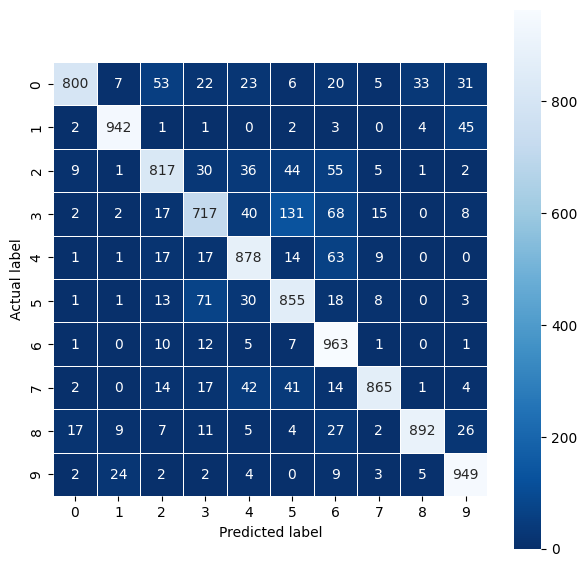

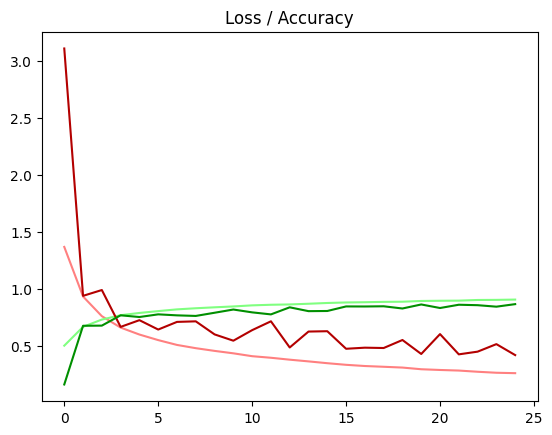

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1000
           1       0.95      0.94      0.95      1000
           2       0.86      0.82      0.84      1000
           3       0.80      0.72      0.75      1000
           4       0.83      0.88      0.85      1000
           5       0.77      0.85      0.81      1000
           6       0.78      0.96      0.86      1000
           7       0.95      0.86      0.90      1000
           8       0.95      0.89      0.92      1000
           9       0.89      0.95      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



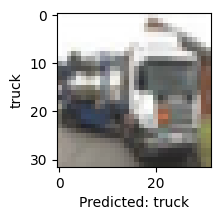

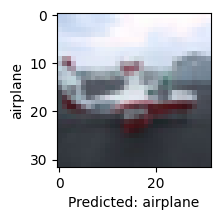

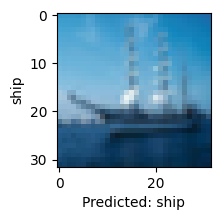

In [ ]:
evaluate_model(model10, history10, x_test, y_test, 'model_10')

### Model 11

A deeper network, replicating the VGG architecture with multiple convolutional layers, BatchNormalization, and Dropout.

In [ ]:
model11 = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile model
model11.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Time the model training
start_time = time.time()

# Train the model
history11 = model11.fit(train_generator, epochs=25, validation_data=(x_test, y_test), callbacks=[early_stopping])

print(f"Model training time: {time.time() - start_time} seconds")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 109ms/step - accuracy: 0.1989 - loss: 2.2075 - val_accuracy: 0.1465 - val_loss: 4.4107
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.3722 - loss: 1.6362 - val_accuracy: 0.4151 - val_loss: 1.4803
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.4363 - loss: 1.4633 - val_accuracy: 0.3614 - val_loss: 2.1152
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.5116 - loss: 1.3325 - val_accuracy: 0.4988 - val_loss: 1.4412
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.5834 - loss: 1.1950 - val_accuracy: 0.4271 - val_loss: 4.2030
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.6291 - loss: 1.0840 - val_accuracy: 0.6549 - val_loss: 1.0888
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.6595 - loss: 1.0117 - val_accuracy: 0.6520 - val_loss: 1.1081
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.6839 - loss: 0.9359 - val_accura

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


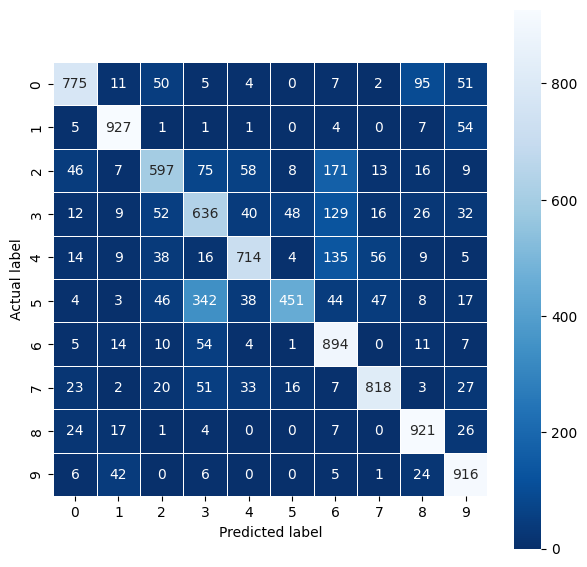

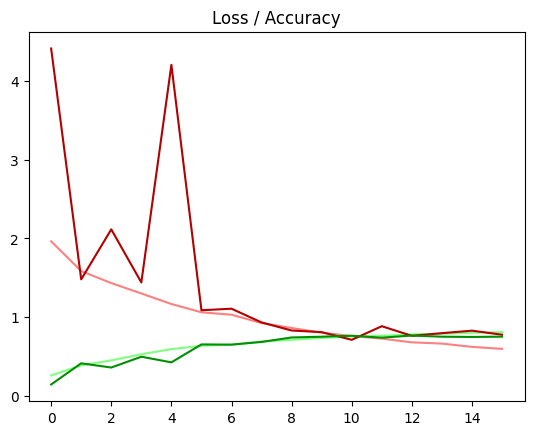

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1000
           1       0.89      0.93      0.91      1000
           2       0.73      0.60      0.66      1000
           3       0.53      0.64      0.58      1000
           4       0.80      0.71      0.75      1000
           5       0.85      0.45      0.59      1000
           6       0.64      0.89      0.74      1000
           7       0.86      0.82      0.84      1000
           8       0.82      0.92      0.87      1000
           9       0.80      0.92      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.76      0.76     10000



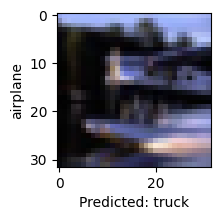

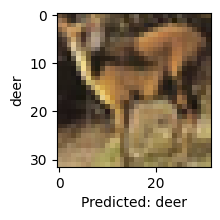

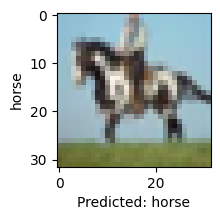

In [ ]:
evaluate_model(model11, history11, x_test, y_test, 'model_11')

In [ ]:
clear_session()

## Learning Transfer

### Model 12

Utilizes transfer learning with VGG16 pre-trained on ImageNet. Fine-tuning is disabled (model12.trainable = False), leveraging the learned features for this specific task.

In [ ]:
model12 = VGG16(weights='imagenet', include_top=False, classes=10, input_shape=(32,32,3))
model12.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model12.trainable = False

model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,870,666 (7.14 MB)

 Trainable params: 134,666 (526.04 KB)

 Non-trainable params: 1,736,000 (6.62 MB)

In [40]:
# To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using keras  utilities

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
)
train_generator = datagen.flow(x_train, y_train, batch_size=128)

history12 = model12.fit(train_generator, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.8020 - loss: 0.5677 - val_accuracy: 0.7500 - val_loss: 0.7509
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.7973 - loss: 0.5695 - val_accuracy: 0.7553 - val_loss: 0.7514
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.8005 - loss: 0.5601 - val_accuracy: 0.7513 - val_loss: 0.7517
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.7980 - loss: 0.5699 - val_accuracy: 0.7506 - val_loss: 0.7680
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.8035 - loss: 0.5543 - val_accuracy: 0.7474 - val_loss: 0.7723
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.8016 - loss: 0.5553 - val_accuracy: 0.7540 - val_loss: 0.7516
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.8041 - loss: 0.5480 - val_accuracy: 0.7465 - val_loss: 0.7743
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.7995 - loss: 0.5548 - val_accurac

#### Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


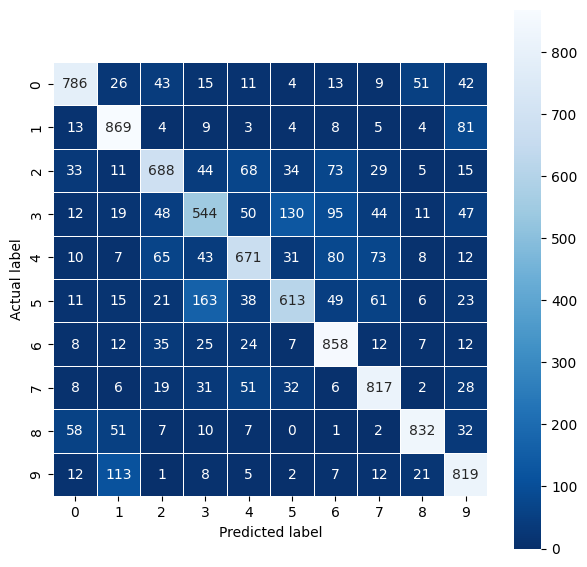

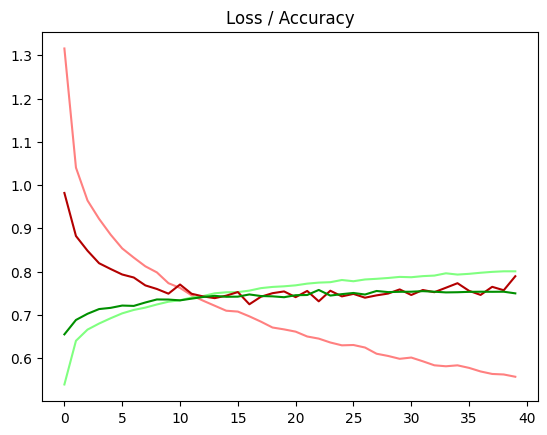

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1000
           1       0.77      0.87      0.82      1000
           2       0.74      0.69      0.71      1000
           3       0.61      0.54      0.58      1000
           4       0.72      0.67      0.70      1000
           5       0.72      0.61      0.66      1000
           6       0.72      0.86      0.78      1000
           7       0.77      0.82      0.79      1000
           8       0.88      0.83      0.85      1000
           9       0.74      0.82      0.78      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



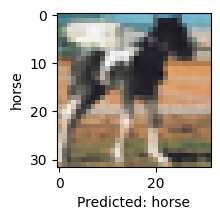

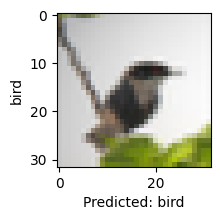

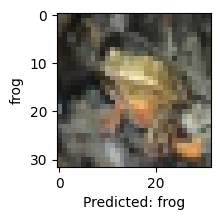

In [ ]:
evaluate_model(model12, history12, x_test, y_test, 'model_12')